In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import pickle
import random
import numpy as np
from torchvision.datasets import MNIST
from PIL import Image
import torchvision
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 150
import IPython
import os
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/anaconda/envs/hw_094295_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_datasets(train_dir, val_dir):
    """Loads and transforms the datasets."""
    # Resize the samples and transform them into tensors
    data_transforms = transforms.Compose([transforms.Resize([128, 128]), 
                                          transforms.ToTensor()])

    # Create a pytorch dataset from a directory of images
    train_dataset = datasets.ImageFolder(train_dir, data_transforms)
    val_dataset = datasets.ImageFolder(val_dir, data_transforms)

    return train_dataset, val_dataset

In [3]:
base_dir = os.path.join("/home/student/hw2_094295", "data")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
aug_dir = os.path.join("/home/student/hw2_094295", "filtered_augmentations")

In [4]:
def load_datasets_with_augmentations(aug_dir):
    data_transforms = transforms.Compose([transforms.Resize([64, 64]), 
                                          transforms.ToTensor()])
    aug_data = []
    for folder_name in os.listdir(aug_dir):
        folder_path = os.path.join(aug_dir, folder_name)
        if os.path.isdir(folder_path) and folder_name in ["Random_rotation", "Regular", "Rotation_with_noise_by_other", "noised_by_other"]:
            aug_data.append(datasets.ImageFolder(folder_path, data_transforms))
    return torch.utils.data.ConcatDataset(aug_data)

In [5]:
aug_dataset = load_datasets_with_augmentations(aug_dir)
# original_train_dataset, original_val_dataset = load_datasets(train_dir, val_dir)
# train_val_sets = torch.utils.data.ConcatDataset([original_train_dataset, original_val_dataset])
# images = torch.stack([img_t for img_t, _ in train_val_sets], dim=3)
# images_mean = images.view(3, -1).mean(dim=1)
# images_std = images.view(3, -1).std(dim=1)
# print(f"images mean: {images_mean}")
# print(f"images std: {images_std}")

In [6]:
print("dataset size", len(aug_dataset))
class_names = ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']
print(class_names)

dataset size 7130
['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


In [7]:
from torch.utils.data import Subset
classes_datasets = {}
for label_index, label in tqdm(enumerate(class_names)):
    indices = [i for i in range(len(aug_dataset)) if aug_dataset[i][1] == label_index]
    class_dataset = Subset(aug_dataset, indices)
    classes_datasets[label] = class_dataset

10it [01:02,  6.27s/it]


### **Gaussian vae**

In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dims, input_dim):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(input_dim, 512)
        self.linear2 = nn.Linear(512,256)
        self.to_mean_logvar = nn.Linear(256, 2*latent_dims)
        
    def reparametrization_trick(self, mu, log_var):
        # Using reparameterization trick to sample from a gaussian
        eps = torch.randn_like(log_var)
        return mu + torch.exp(log_var / 2) * eps
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        mu, log_var = torch.split(self.to_mean_logvar(x),2, dim=-1)
        self.kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return self.reparametrization_trick(mu, log_var)

class Decoder(nn.Module):
    def __init__(self, latent_dims, output_dim):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 256)
        self.linear2 = nn.Linear(256, 512)
        self.linear3 = nn.Linear(512, output_dim)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        z = torch.sigmoid(self.linear3(z))
        z = z.reshape(-1, 3,64,64)
        return z


class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, input_dim, output_dim):
        super().__init__()
        self.encoder = Encoder(latent_dims, input_dim)
        self.decoder = Decoder(latent_dims, output_dim)
    
    def forward(self, x):
        z = self.encoder(x)        
        return self.decoder(z)

In [7]:
def train(vae, data, epochs=20):
    optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
    running_loss = 0.0
    for epoch in range(epochs):
        running_loss = 0.0
        print(f'Epoch {epoch + 1}')
        print("-"*40)
        for x, y in data:
            x = x.to(device)
            optimizer.zero_grad()
            x_hat = vae(x)
            loss = F.binary_cross_entropy(x_hat, x, reduction='sum') + vae.encoder.kl
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f"Epoch loss: {running_loss} \n")
        
    return vae


def plot_latent(autoencoder, data, num_batches=120):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        
    plt.colorbar()
    plt.title("Latent visualization")

def plot_reconstructed(autoencoder,  r0=(-5, 10), r1=(-10, 5), n=12):
    img = []
    for i, z2 in enumerate(np.linspace(r1[1],r1[0], n)):
        for j, z1 in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[z1, z2]]).to(device)
            x_hat = autoencoder.decoder(z)
            img.append(x_hat)
            
    img = torch.cat(img)
    img = torchvision.utils.make_grid(img,nrow=n).permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow(img,extent=[*r0, *r1])
    plt.title(f"z0 : {r0}, z1: {r1}", fontweight = "bold")

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 160

def main():
    z_dim = 2
    input_dim = 64*64*3
    output_dim = 64*64*3
    all_dataloader = torch.utils.data.DataLoader(aug_dataset, batch_size=BATCH_SIZE, shuffle=True)

    vae = VariationalAutoencoder(z_dim, input_dim, output_dim).to(device)
    vae = train(vae, all_dataloader, epochs=100)

    plot_latent(vae, all_dataloader)

    return vae

Epoch 1
----------------------------------------
Epoch loss: 37872334.033203125 

Epoch 2
----------------------------------------
Epoch loss: 33532745.810546875 

Epoch 3
----------------------------------------
Epoch loss: 32827516.560546875 

Epoch 4
----------------------------------------
Epoch loss: 31774829.203125 

Epoch 5
----------------------------------------
Epoch loss: 30883072.943359375 

Epoch 6
----------------------------------------
Epoch loss: 31053375.423828125 

Epoch 7
----------------------------------------
Epoch loss: 30166593.439453125 

Epoch 8
----------------------------------------
Epoch loss: 29973967.204101562 

Epoch 9
----------------------------------------
Epoch loss: 29729344.8046875 

Epoch 10
----------------------------------------
Epoch loss: 29610231.33203125 

Epoch 11
----------------------------------------
Epoch loss: 29524044.626953125 

Epoch 12
----------------------------------------
Epoch loss: 29469412.908203125 

Epoch 13
----------

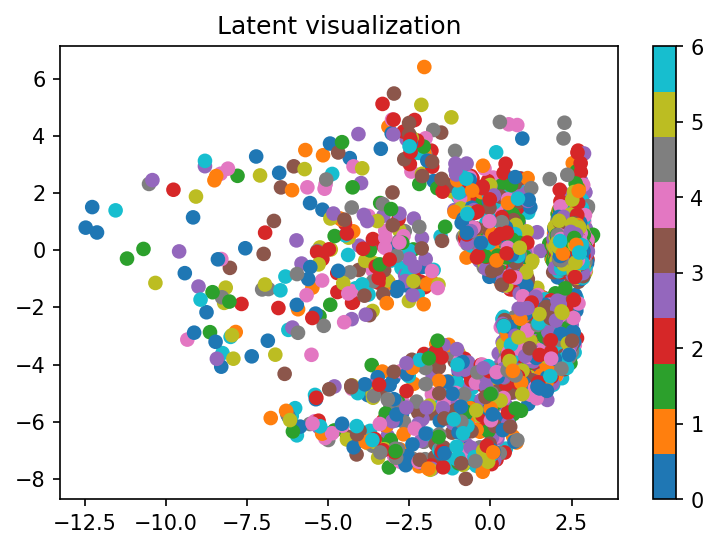

In [13]:
vae = main()

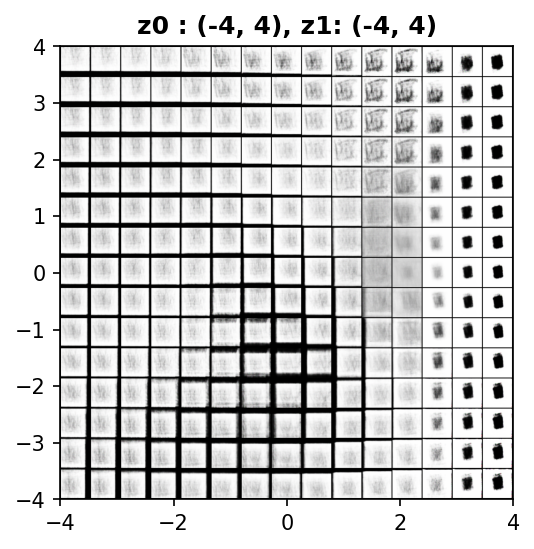

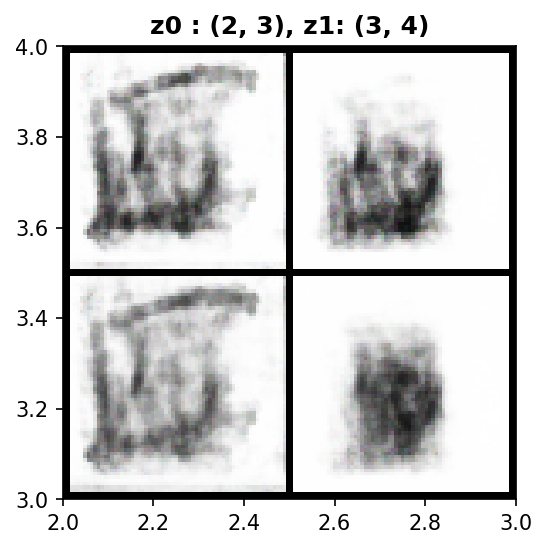

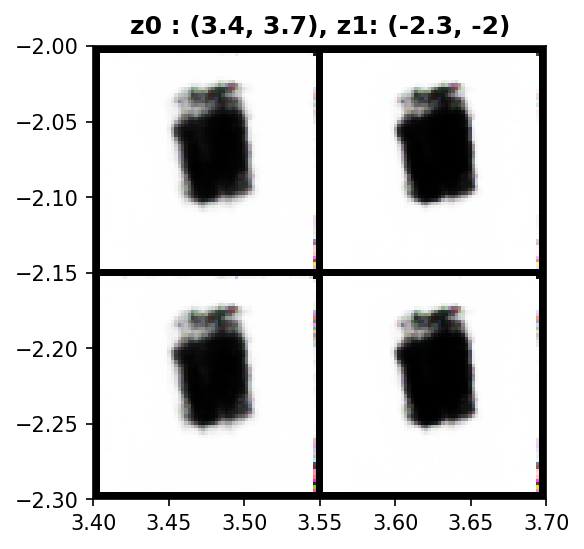

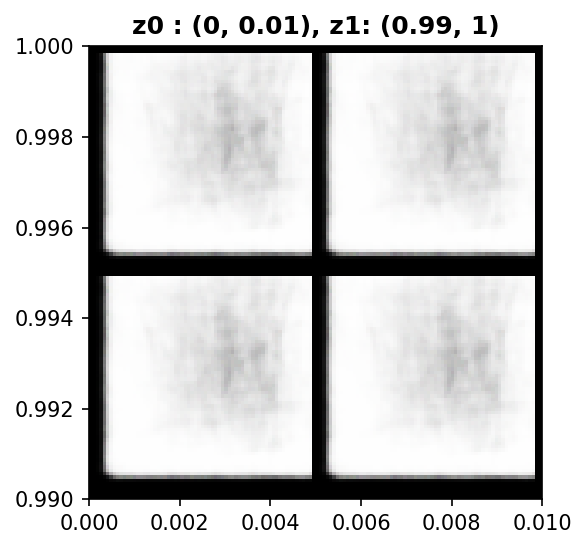

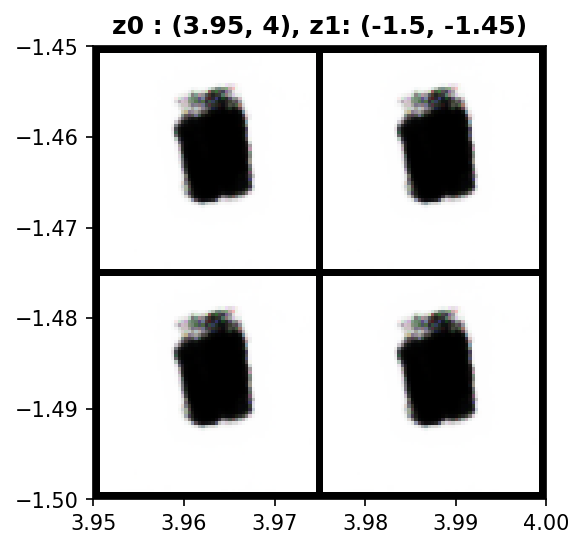

In [14]:
plot_reconstructed(vae,  r0=(-4, 4), r1=(-4, 4), n=15)
plt.show()
plot_reconstructed(vae,  r0=(2, 3), r1=(3, 4), n=2)
plt.show()
plot_reconstructed(vae,  r0=(3.4, 3.7), r1=(-2.3, -2), n=2)
plt.show()
plot_reconstructed(vae,  r0=(0, 0.01), r1=(0.99, 1), n=2)
plt.show()
plot_reconstructed(vae,  r0=(3.95, 4), r1=(-1.5, -1.45), n=2)
plt.show()

### **GAN** 

In [15]:
batch_size = 40
image_size = 128
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 60
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 150
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [10]:
def weights_init(m):
	classname = m.__class__.__name__
	if classname.find('Conv') != -1:
		nn.init.normal_(m.weight.data, 0.0, 0.02)
	elif classname.find('BatchNorm') != -1:
		nn.init.normal_(m.weight.data, 1.0, 0.02)
		nn.init.constant_(m.bias.data, 0)

In [11]:
class Generator(nn.Module):
	def __init__(self, ngpu):
		super(Generator, self).__init__()
		self.ngpu = ngpu
		self.main = nn.Sequential(
			# input is Z, going into a convolution
			nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
			nn.BatchNorm2d(ngf * 8),
			nn.ReLU(True),
			# state size. (ngf*8) x 4 x 4
			nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
			nn.BatchNorm2d(ngf * 4),
			nn.ReLU(True),
			# state size. (ngf*4) x 8 x 8
			nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
			nn.BatchNorm2d(ngf * 2),
			nn.ReLU(True),
			# state size. (ngf*2) x 16 x 16
			nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
			nn.BatchNorm2d(ngf),
			nn.ReLU(True),
			# state size. (ngf) x 32 x 32
			nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
			nn.Tanh()
			# state size. (nc) x 64 x 64
		)

	def forward(self, input):
		return self.main(input)

In [12]:
class Discriminator(nn.Module):
	def __init__(self, ngpu):
		super(Discriminator, self).__init__()
		self.ngpu = ngpu
		self.main = nn.Sequential(
			# input is (nc) x 64 x 64
			nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
			nn.LeakyReLU(0.2, inplace=True),
			# state size. (ndf) x 32 x 32
			nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
			nn.BatchNorm2d(ndf * 2),
			nn.LeakyReLU(0.2, inplace=True),
			# state size. (ndf*2) x 16 x 16
			nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
			nn.BatchNorm2d(ndf * 4),
			nn.LeakyReLU(0.2, inplace=True),
			# state size. (ndf*4) x 8 x 8
			nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
			nn.BatchNorm2d(ndf * 8),
			nn.LeakyReLU(0.2, inplace=True),
			# state size. (ndf*8) x 4 x 4
			nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
			nn.Sigmoid()
		)

	def forward(self, input):
		return self.main(input)

In [17]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
# all_dataloader = torch.utils.data.DataLoader(aug_dataset, batch_size=batch_size, shuffle=True)
i_dataloader = torch.utils.data.DataLoader(classes_datasets["i"], batch_size=batch_size, shuffle=True)

Starting Training Loop...
[0/150][0/22]	Loss_D: 1.2442	Loss_G: 6.3172	D(x): 0.6431	D(G(z)): 0.4702 / 0.0028


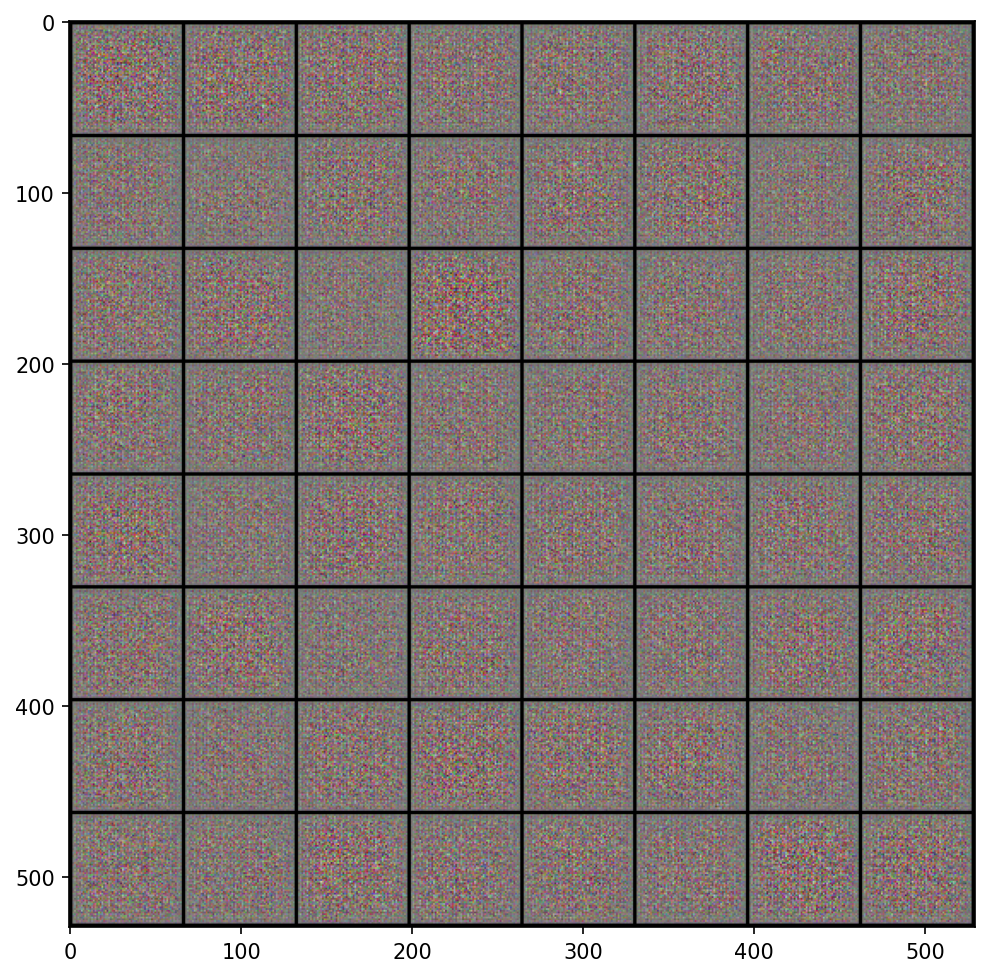

[1/150][0/22]	Loss_D: 0.3896	Loss_G: 22.9103	D(x): 1.0000	D(G(z)): 0.2913 / 0.0000
[2/150][0/22]	Loss_D: 0.0000	Loss_G: 36.6311	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/150][0/22]	Loss_D: 0.5813	Loss_G: 29.3627	D(x): 0.7972	D(G(z)): 0.0000 / 0.0000
[4/150][0/22]	Loss_D: 0.3448	Loss_G: 5.4604	D(x): 0.8590	D(G(z)): 0.0002 / 0.0049
[5/150][0/22]	Loss_D: 0.7364	Loss_G: 4.9364	D(x): 0.6916	D(G(z)): 0.0052 / 0.0081
[6/150][0/22]	Loss_D: 0.2637	Loss_G: 8.4489	D(x): 0.9823	D(G(z)): 0.2106 / 0.0002
[7/150][0/22]	Loss_D: 1.5392	Loss_G: 3.9876	D(x): 0.3531	D(G(z)): 0.0003 / 0.0579
[8/150][0/22]	Loss_D: 0.3176	Loss_G: 5.9585	D(x): 0.7589	D(G(z)): 0.0030 / 0.0091
[9/150][0/22]	Loss_D: 0.1320	Loss_G: 5.1103	D(x): 0.9568	D(G(z)): 0.0817 / 0.0080
[10/150][0/22]	Loss_D: 0.3213	Loss_G: 13.3768	D(x): 0.7993	D(G(z)): 0.0002 / 0.0000
[11/150][0/22]	Loss_D: 0.0299	Loss_G: 6.3492	D(x): 0.9756	D(G(z)): 0.0047 / 0.0020
[12/150][0/22]	Loss_D: 0.1925	Loss_G: 6.6048	D(x): 0.8504	D(G(z)): 0.0029 / 0.0028
[13/150][

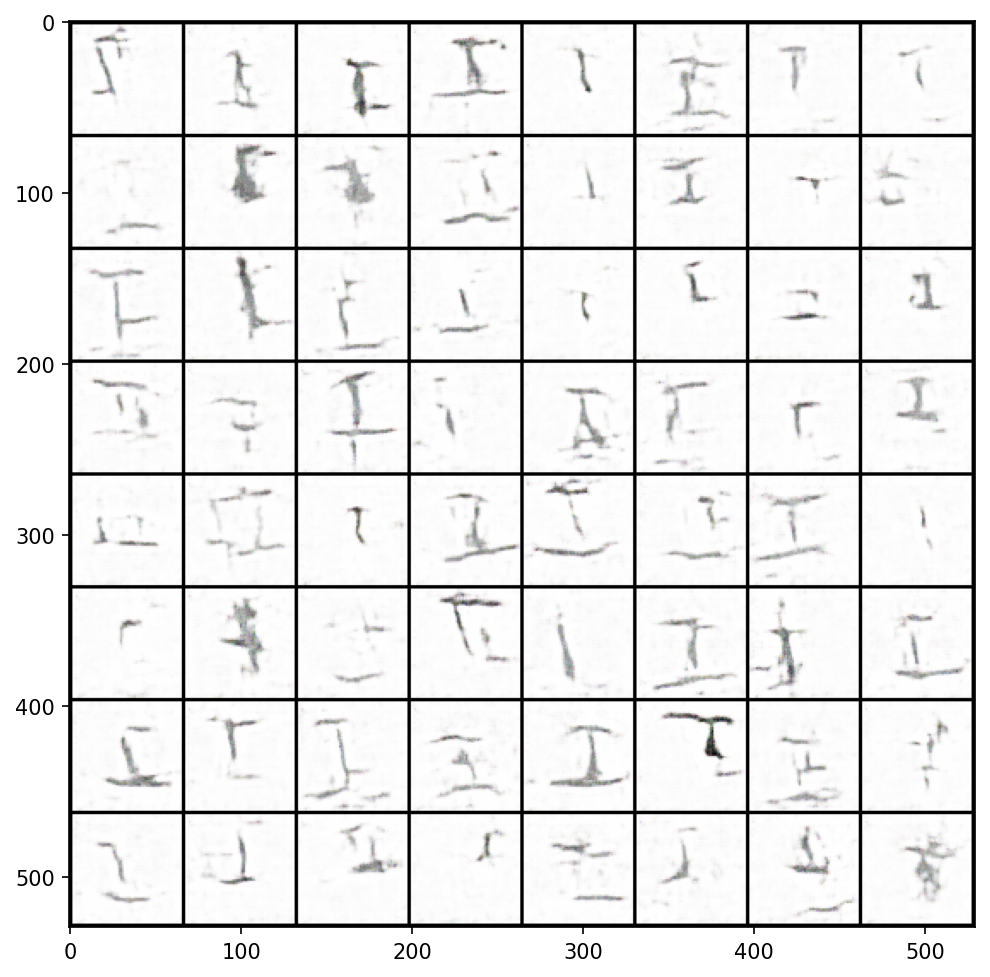

[69/150][0/22]	Loss_D: 0.0981	Loss_G: 5.0240	D(x): 0.9864	D(G(z)): 0.0776 / 0.0117
[70/150][0/22]	Loss_D: 0.0827	Loss_G: 3.9603	D(x): 0.9720	D(G(z)): 0.0506 / 0.0273
[71/150][0/22]	Loss_D: 0.0961	Loss_G: 3.6972	D(x): 0.9380	D(G(z)): 0.0276 / 0.0399
[72/150][0/22]	Loss_D: 0.0935	Loss_G: 4.1294	D(x): 0.9713	D(G(z)): 0.0581 / 0.0206
[73/150][0/22]	Loss_D: 0.0876	Loss_G: 4.7906	D(x): 0.9739	D(G(z)): 0.0540 / 0.0176
[74/150][0/22]	Loss_D: 0.0710	Loss_G: 5.2295	D(x): 0.9835	D(G(z)): 0.0493 / 0.0092
[75/150][0/22]	Loss_D: 0.1328	Loss_G: 5.6540	D(x): 0.9885	D(G(z)): 0.1091 / 0.0051
[76/150][0/22]	Loss_D: 2.7888	Loss_G: 6.6680	D(x): 0.9828	D(G(z)): 0.7649 / 0.0236
[77/150][0/22]	Loss_D: 0.2844	Loss_G: 3.3636	D(x): 0.8310	D(G(z)): 0.0559 / 0.0690
[78/150][0/22]	Loss_D: 0.2508	Loss_G: 3.5935	D(x): 0.9457	D(G(z)): 0.1494 / 0.0421
[79/150][0/22]	Loss_D: 0.1170	Loss_G: 4.2218	D(x): 0.9688	D(G(z)): 0.0723 / 0.0241
[80/150][0/22]	Loss_D: 0.0888	Loss_G: 4.1324	D(x): 0.9448	D(G(z)): 0.0296 / 0.0266
[81/

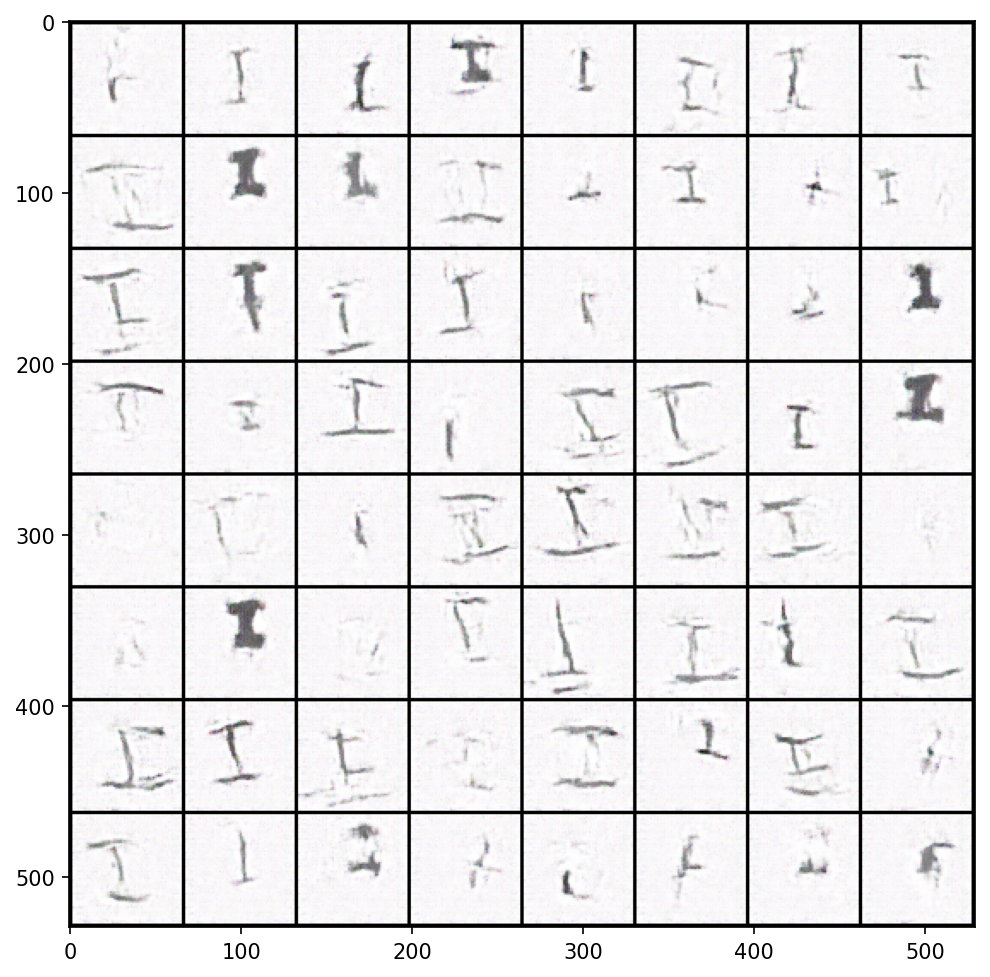

[137/150][0/22]	Loss_D: 0.0312	Loss_G: 5.3916	D(x): 0.9818	D(G(z)): 0.0124 / 0.0088
[138/150][0/22]	Loss_D: 0.0177	Loss_G: 5.3605	D(x): 0.9907	D(G(z)): 0.0081 / 0.0094
[139/150][0/22]	Loss_D: 0.0357	Loss_G: 5.3233	D(x): 0.9864	D(G(z)): 0.0209 / 0.0100
[140/150][0/22]	Loss_D: 0.0250	Loss_G: 5.2138	D(x): 0.9907	D(G(z)): 0.0153 / 0.0101
[141/150][0/22]	Loss_D: 0.0339	Loss_G: 5.6597	D(x): 0.9858	D(G(z)): 0.0180 / 0.0075
[142/150][0/22]	Loss_D: 0.0262	Loss_G: 5.0033	D(x): 0.9881	D(G(z)): 0.0139 / 0.0109
[143/150][0/22]	Loss_D: 0.0140	Loss_G: 5.0346	D(x): 0.9982	D(G(z)): 0.0121 / 0.0095
[144/150][0/22]	Loss_D: 0.0157	Loss_G: 5.8040	D(x): 0.9921	D(G(z)): 0.0076 / 0.0066
[145/150][0/22]	Loss_D: 0.0133	Loss_G: 5.9291	D(x): 0.9917	D(G(z)): 0.0048 / 0.0054
[146/150][0/22]	Loss_D: 1.5403	Loss_G: 3.9149	D(x): 0.8769	D(G(z)): 0.5231 / 0.0471
[147/150][0/22]	Loss_D: 0.3739	Loss_G: 5.4277	D(x): 0.9438	D(G(z)): 0.2070 / 0.0099
[148/150][0/22]	Loss_D: 0.1106	Loss_G: 4.4848	D(x): 0.9488	D(G(z)): 0.0505 /

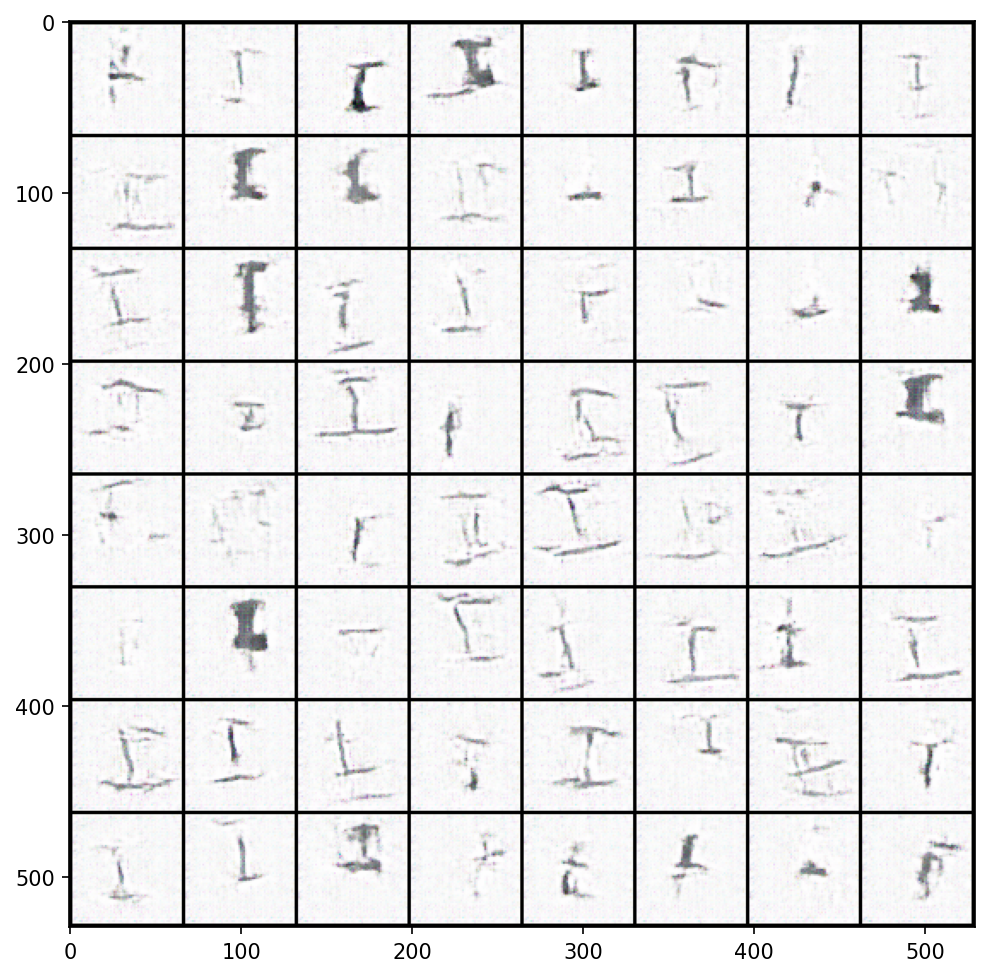

In [18]:
# Training Loop
import random
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(i_dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
    
        ## Train with all-fake batch
        # Generate batch of latent vectors
        # z_discriminate = torch.randint(-10,11,(b_size, nz, 1, 1)).to(device) / 10
        z_continuous = torch.randn(b_size, nz, 1, 1, device=device)
        noise = z_continuous # + z_discriminate
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
       
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(i_dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 1500 == 0) or ((epoch == num_epochs-1) and (i == len(i_dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=False))
            plt.figure(figsize=(8,8))
            plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True),(1,2,0)))
            plt.show()
            
        iters += 1


In [ ]:
from torchvision.utils import save_image

generated_images = []
img_index = 0
for i in range(5):
    z_continuous = torch.randn(b_size, nz, 1, 1, device=device)
    fake_images = netG(z_continuous).detach().cpu()
    for img in fake_images:
        save_image(img, f'/home/student/hw2_094295/GAN/image_i_{img_index}.png')
        img_index += 1

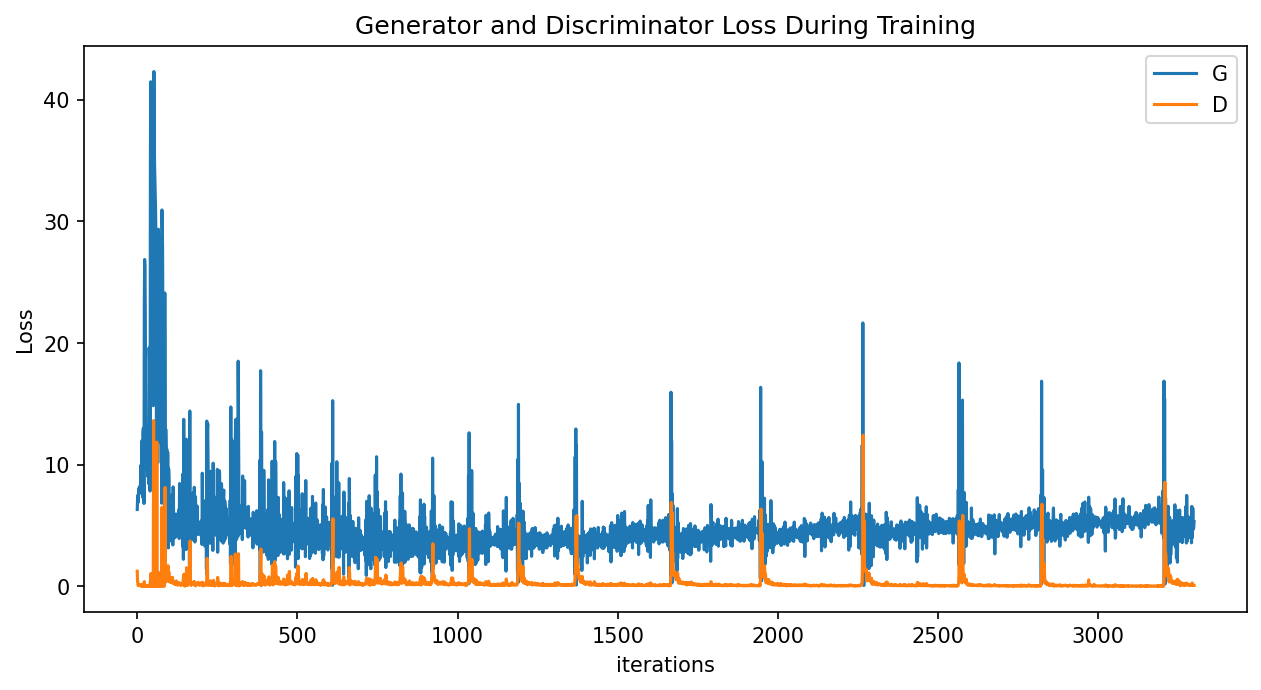

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

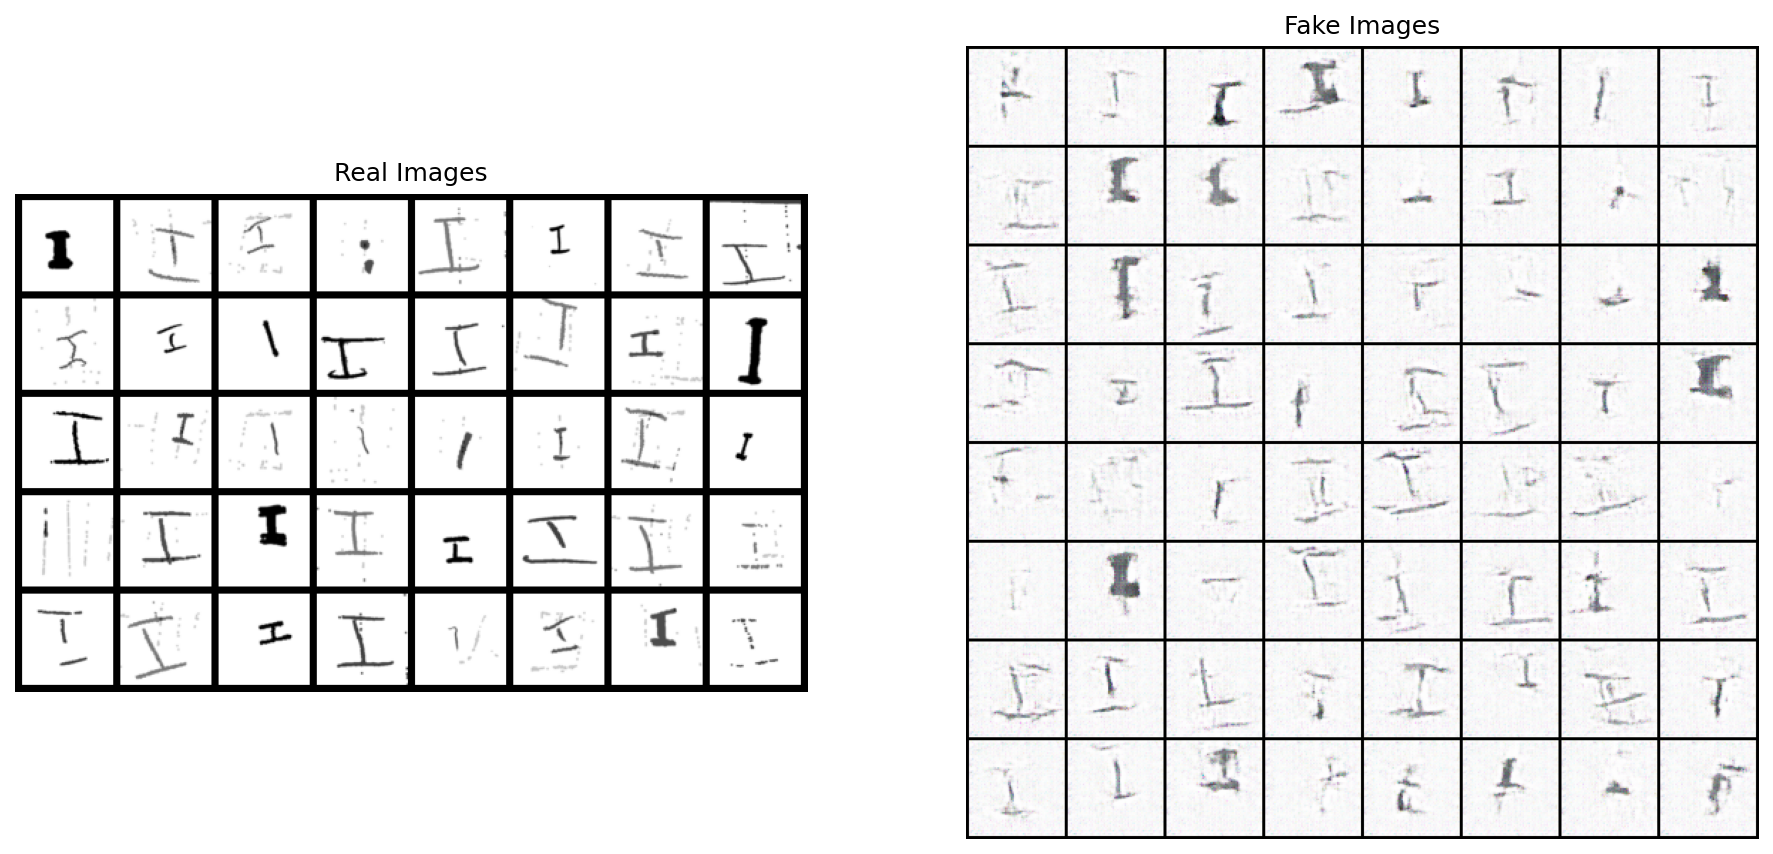

In [20]:
real_batch = next(iter(i_dataloader))

# Plot the real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
fake = netG(fixed_noise).detach().cpu()
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1, 2, 0)))
plt.savefig("real_vs_fake.png")